In [ ]:
%%capture
%load_ext autoreload
%autoreload 2
%reset -f

In [ ]:
import jax
import numpy as np
from jax import numpy as jnp
from jax.numpy import fft
from matplotlib import pyplot as plt

from otf import optim
from otf import time_integration as ti
from otf.syncd import utils
from otf.system import System_ModelKnown, utils as system_utils

from plot import plot

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

jndarray = jnp.ndarray

In [ ]:
def get_initial_values(x0: float, xf: float, n: int):
    """Get initial values for the true and nudged states.

    Parameters
    ----------
    x0, xf
        Endpoints of domain
    n
        Number of spatial grid points on [x0, xf]

    Returns
    -------
    u0
        Initial true state
    un0
        Initial nudged state
    """
    # Initial true state
    u = lambda x: np.array(
        [
            0.2 * jnp.exp(-10 * (x - 5) ** 2),
            -4 * (x - 5) * np.exp(-10 * (x - 5) ** 2),
        ]
    )
    xls = jnp.linspace(x0, xf, n)
    u0 = u(xls)

    # Initial simulation state
    un0 = jnp.zeros_like(u0)

    return fft.rfft(u0), fft.rfft(un0)

In [ ]:
def compute_spatial_derivative(s: jndarray, m: int, k: jndarray) -> jndarray:
    """Compute mth spatial derivative of the state.

    Parameters
    ----------
    s
        System state (e.g., true or nudged) at a point in time in frequency
        domain
    m
        Number of spatial derivatives to take
    k
        Wave numbers

    Returns
    -------
    d^m s / d {x^m}
        Approximation of mth spatial derivative of s
    """
    return (2 * jnp.pi * 1j * k) ** m * s

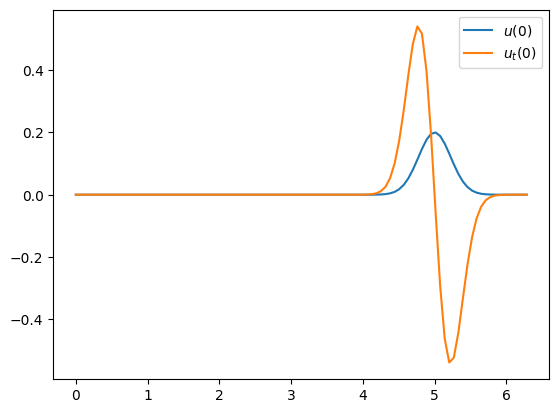

In [ ]:
def true_ode(gs: jndarray, true: jndarray, k: jndarray) -> jndarray:
    u, ut = true
    return jnp.array([ut, gs * compute_spatial_derivative(u, 2, k)])


def assimilated_ode(
    cs: jndarray, assimilated: jndarray, k: jndarray
) -> jndarray:
    u, ut = assimilated
    return jnp.array([ut, cs * compute_spatial_derivative(u, 2, k)])


# System evolution parameters
g = 1
c = g
c *= 0.5
mu = 1
x0, xf = 0, 2 * np.pi
xn = 100
k = fft.rfftfreq(xn, (xf - x0) / xn)

gs = jnp.array([g], dtype=complex)
cs = jnp.array([c], dtype=complex)

true0, assimilated0 = get_initial_values(x0, xf, xn)

flat_true_ode = system_utils.flatten_ode(
    lambda gs, true: true_ode(gs, true, k),
    true0.shape,
)
flat_assimilated_ode = system_utils.flatten_ode(
    lambda cs, assimilated: assimilated_ode(cs, assimilated, k),
    assimilated0.shape,
)

observed_slice = jnp.s_[:]
observed_mask = system_utils.mask_from_slice(observed_slice, true0.shape)
system = System_ModelKnown(
    mu,
    gs,
    cs,
    observed_mask,
    flat_assimilated_ode,
    flat_true_ode,
    complex_differentiation=True,
)
solver = ti.RK4(system)
optimizer = optim.LevenbergMarquardt(system, 1e-1)

# Simulation parameters
dt = 0.04
T0, Tf = 0, 400
t_relax = 1

init = get_initial_values(x0, xf, xn)[0]
plt.plot(np.linspace(x0, xf, xn), fft.irfft(init[0]), label="$u(0)$")
plt.plot(np.linspace(x0, xf, xn), fft.irfft(init[1]), label="$u_t(0)$")
plt.legend()
plt.show()

return_all = True
cs, u_errors, tls, true, nudged = utils.run_update(
    system,
    solver,
    dt,
    T0,
    Tf,
    t_relax,
    true0.ravel(),
    assimilated0.ravel(),
    optimizer,
    return_all=return_all,
)

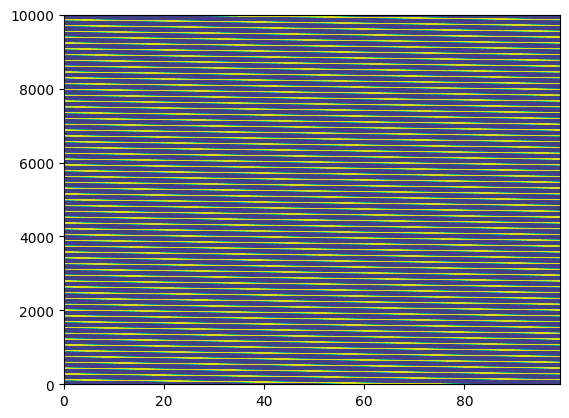

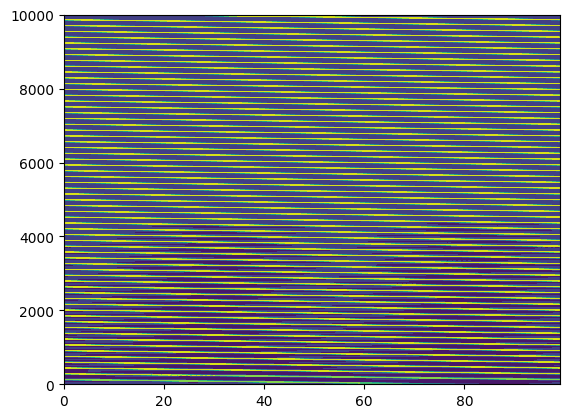

In [ ]:
plt.contourf(fft.irfft(true.reshape(-1, *true0.shape)[:, 0, :]))
plt.show()

plt.contourf(fft.irfft(nudged.reshape(-1, *assimilated0.shape)[:, 0, :]))
plt.show()

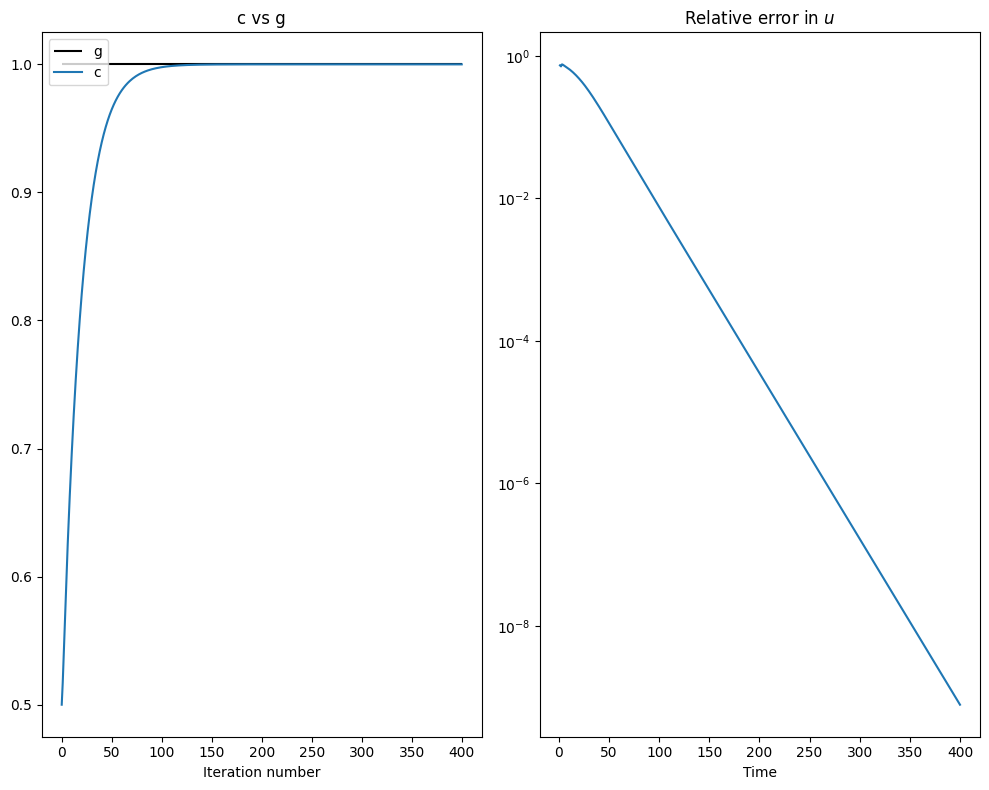

In [ ]:
fig, axs = plot(cs.T[0].real, u_errors, g, tls)
plt.show()